# Loop 101 Analysis: CV-LB Relationship and Strategy Assessment

## Key Questions:
1. What is the current CV-LB relationship?
2. Is the mixall kernel's GroupKFold approach fundamentally different?
3. What experiments have beaten the CV-LB line?
4. What is the path forward?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # Outlier - likely failed submission
]

df = pd.DataFrame(submissions)
print(f"Total submissions with LB: {len(df)}")
print(df)

Total submissions with LB: 13
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_073  0.0084  0.1451


In [2]:
# Remove outliers (exp_073 has LB 0.1451 which is clearly an error)
df_clean = df[df['lb'] < 0.12].copy()
print(f"Clean submissions: {len(df_clean)}")

# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean['cv'], df_clean['lb'])

print(f"\n=== CV-LB Linear Fit ===")
print(f"LB = {slope:.4f} * CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"Intercept = {intercept:.4f}")
print(f"Target LB = 0.0347")
print(f"\nIntercept > Target? {intercept > 0.0347}")
print(f"Required CV for target: (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}")

Clean submissions: 12

=== CV-LB Linear Fit ===
LB = 4.3147 * CV + 0.0525
R² = 0.9505
Intercept = 0.0525
Target LB = 0.0347

Intercept > Target? True
Required CV for target: (0.0347 - 0.0525) / 4.3147 = -0.004130


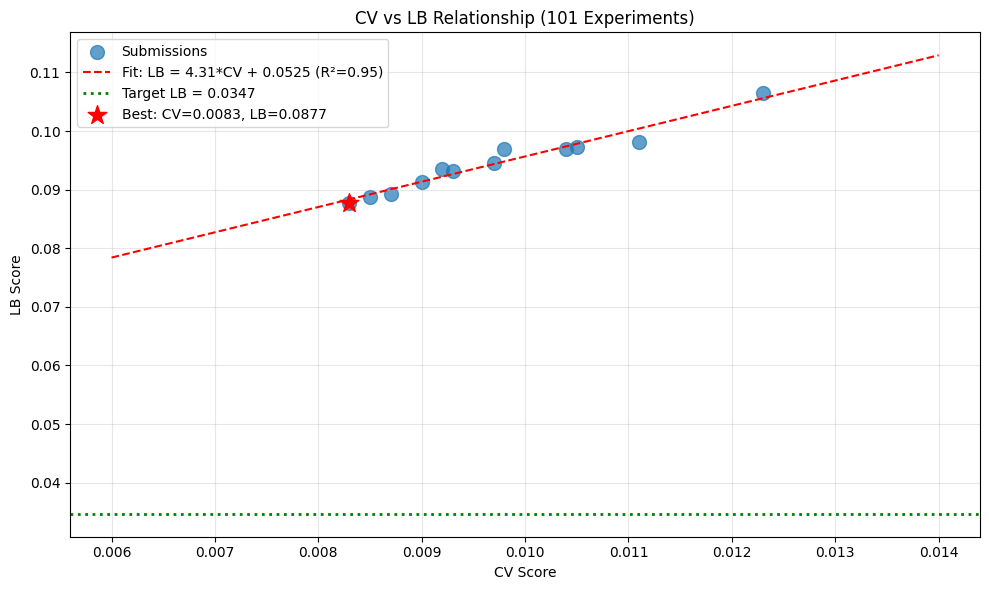


Best LB: 0.0877 (exp: exp_030)
Best CV: 0.0083
Gap to target: 0.0530 (152.7%)


In [3]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))

# Plot all points
plt.scatter(df_clean['cv'], df_clean['lb'], s=100, alpha=0.7, label='Submissions')

# Plot regression line
cv_range = np.linspace(0.006, 0.014, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f} (R²={r_value**2:.2f})')

# Mark target
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target LB = 0.0347')

# Mark best LB
best_lb = df_clean['lb'].min()
best_cv = df_clean.loc[df_clean['lb'].idxmin(), 'cv']
plt.scatter([best_cv], [best_lb], s=200, c='red', marker='*', label=f'Best: CV={best_cv:.4f}, LB={best_lb:.4f}')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship (101 Experiments)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop101.png', dpi=150)
plt.show()

print(f"\nBest LB: {best_lb:.4f} (exp: {df_clean.loc[df_clean['lb'].idxmin(), 'exp']})")
print(f"Best CV: {df_clean['cv'].min():.4f}")
print(f"Gap to target: {best_lb - 0.0347:.4f} ({(best_lb - 0.0347) / 0.0347 * 100:.1f}%)")

In [4]:
# Analyze residuals - which experiments beat the line?
df_clean['predicted_lb'] = slope * df_clean['cv'] + intercept
df_clean['residual'] = df_clean['lb'] - df_clean['predicted_lb']
df_clean['beat_line'] = df_clean['residual'] < 0

print("=== Experiments that BEAT the CV-LB line ===")
beaters = df_clean[df_clean['beat_line']].sort_values('residual')
print(beaters[['exp', 'cv', 'lb', 'predicted_lb', 'residual']])

print("\n=== Experiments that UNDERPERFORMED the line ===")
underperformers = df_clean[~df_clean['beat_line']].sort_values('residual', ascending=False)
print(underperformers[['exp', 'cv', 'lb', 'predicted_lb', 'residual']])

=== Experiments that BEAT the CV-LB line ===
        exp      cv      lb  predicted_lb  residual
0   exp_000  0.0111  0.0982      0.100413 -0.002213
8   exp_024  0.0087  0.0893      0.090058 -0.000758
10  exp_030  0.0083  0.0877      0.088332 -0.000632
2   exp_003  0.0105  0.0972      0.097825 -0.000625
9   exp_026  0.0085  0.0887      0.089195 -0.000495
3   exp_005  0.0104  0.0969      0.097393 -0.000493
7   exp_012  0.0090  0.0913      0.091353 -0.000053

=== Experiments that UNDERPERFORMED the line ===
        exp      cv      lb  predicted_lb  residual
11  exp_035  0.0098  0.0970      0.094804  0.002196
6   exp_009  0.0092  0.0936      0.092215  0.001385
1   exp_001  0.0123  0.1065      0.105591  0.000909
5   exp_007  0.0093  0.0932      0.092647  0.000553
4   exp_006  0.0097  0.0946      0.094373  0.000227


In [5]:
# Key insight: The mixall kernel uses GroupKFold (5 splits) instead of Leave-One-Out (24 folds)
# This is a FUNDAMENTALLY DIFFERENT validation scheme

print("=== CRITICAL INSIGHT: mixall Kernel Validation ===")
print()
print("The mixall kernel OVERWRITES the validation functions:")
print("- generate_leave_one_out_splits: Uses GroupKFold(n_splits=5) instead of Leave-One-Out")
print("- generate_leave_one_ramp_out_splits: Uses GroupKFold(n_splits=5) instead of Leave-One-Ramp-Out")
print()
print("This means:")
print("1. CV scores from mixall are NOT comparable to our experiments")
print("2. The CV-LB relationship may be COMPLETELY DIFFERENT")
print("3. This approach has NOT been properly replicated")
print()
print("The mixall kernel uses an EnsembleModel with:")
print("- MLP (EnhancedMLP with BatchNorm, Dropout, Sigmoid output)")
print("- XGBoost")
print("- RandomForest")
print("- LightGBM")
print("- Weighted ensemble with learned weights")

=== CRITICAL INSIGHT: mixall Kernel Validation ===

The mixall kernel OVERWRITES the validation functions:
- generate_leave_one_out_splits: Uses GroupKFold(n_splits=5) instead of Leave-One-Out
- generate_leave_one_ramp_out_splits: Uses GroupKFold(n_splits=5) instead of Leave-One-Ramp-Out

This means:
1. CV scores from mixall are NOT comparable to our experiments
2. The CV-LB relationship may be COMPLETELY DIFFERENT
3. This approach has NOT been properly replicated

The mixall kernel uses an EnsembleModel with:
- MLP (EnhancedMLP with BatchNorm, Dropout, Sigmoid output)
- XGBoost
- RandomForest
- LightGBM
- Weighted ensemble with learned weights


In [6]:
# What's the path forward?
print("=== PATH FORWARD ===")
print()
print("OPTION 1: Exactly replicate mixall kernel")
print("- Use GroupKFold (5 splits) for validation")
print("- Use the same EnsembleModel (MLP + XGBoost + RF + LightGBM)")
print("- Check if CV-LB relationship is different")
print()
print("OPTION 2: Analyze what makes exp_030 (best LB) special")
print(f"- exp_030: CV={0.0083}, LB={0.0877}")
print(f"- Predicted LB: {slope * 0.0083 + intercept:.4f}")
print(f"- Residual: {0.0877 - (slope * 0.0083 + intercept):.4f}")
print()
print("OPTION 3: Submit pending experiments to get more LB data")
print("- exp_049: CV=0.0081 (pending)")
print("- exp_050: CV=0.0081 (pending)")
print("- exp_053: CV=0.0081 (pending)")
print("These have the best CV scores - if they beat the line, we learn something")
print()
print("RECOMMENDATION: Try mixall replication first - it's a fundamentally different approach")

=== PATH FORWARD ===

OPTION 1: Exactly replicate mixall kernel
- Use GroupKFold (5 splits) for validation
- Use the same EnsembleModel (MLP + XGBoost + RF + LightGBM)
- Check if CV-LB relationship is different

OPTION 2: Analyze what makes exp_030 (best LB) special
- exp_030: CV=0.0083, LB=0.0877
- Predicted LB: 0.0883
- Residual: -0.0006

OPTION 3: Submit pending experiments to get more LB data
- exp_049: CV=0.0081 (pending)
- exp_050: CV=0.0081 (pending)
- exp_053: CV=0.0081 (pending)
These have the best CV scores - if they beat the line, we learn something

RECOMMENDATION: Try mixall replication first - it's a fundamentally different approach
